## Cartpole using pixels

In [4]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

import seaborn as sns; sns.set_theme()

import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [5]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [6]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [7]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

### Experience replay (Replay Memory)

In [8]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

### Policy network

#### Network definition

In [9]:
class Conv_DQN(nn.Module):

    def __init__(self, channels, action_space_dim):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = channels, out_channels = 64, kernel_size = 4, stride = 2, padding=0),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            )
        
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(25024, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, action_space_dim)
            )
        

    def forward(self, x):
        x=self.conv(x)
        #print(x.shape)
        return self.linear(x)
    
    

## Exploration Policy

### Epsilon-greedy policy


In [10]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

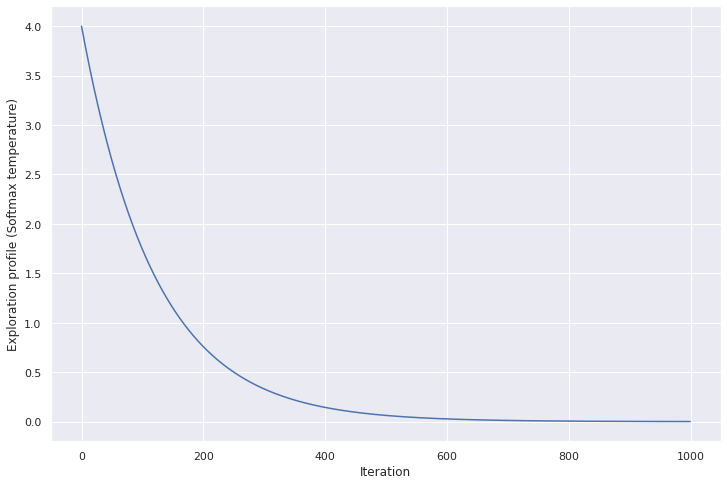

In [11]:
### Define exploration profile
initial_value = 4

num_iterations = 1000

exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)

plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [12]:
def choose_action_softmax(net, state, temperature):
    state = state.to(device)
    net.to(device)
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state).squeeze(0)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out.cpu() / temperature, dim=0).numpy()
    
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.cpu().numpy()

### Network update 
#### Initialization

In [13]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

gamma = 0.98   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [14]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n


state_space_dim=1

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")



STATE SPACE SIZE: 1
ACTION SPACE SIZE: 2


In [26]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = Conv_DQN(1, action_space_dim).to(device)

### Initialize the target network with the same weights of the policy network
target_net = Conv_DQN(1, action_space_dim).to(device)#CNN
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [27]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
   
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch

    states      = torch.stack([s[0][0] for s in batch]).to(device) #CNN
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64).to(device)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32).to(device)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.stack([s[2][0] for s in batch if s[2] is not None]).to(device)
    
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool).to(device)

    # Compute all the Q values (forward pass)
    policy_net.train()
    #print(states[0].shape)
    
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states).to(device)
    next_state_max_q_values = torch.zeros(batch_size).to(device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1).to(device) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values).to(device)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [28]:
def preproces(env):
    pixel= env.render(mode='rgb_array')
    pixel=pixel[150:320,100:500,2]
    pixel = pixel.reshape((1,85, 2, 200, 2)).max(4).max(2)
    pixel = torch.tensor(pixel.copy(), dtype=torch.float32)
    return pixel.unsqueeze(0).to(device)

### Training

In [ ]:
# Initialize the Gym environment
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True)

training_score=[]

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    obs=preproces(env)

    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

        # Choose the action following the policy
        action, q_values = choose_action_softmax(policy_net, obs, temperature=tau)

        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        
        # We apply a (linear) penalty when the cart is far from center
        pos_weight = 1
        reward = reward - pos_weight * np.abs(state[0]) 
        
        # Update the final score (+1 for each step)
        score += 1

        # Apply penalty for bad state
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None
            next_state_obs=None
            
        if type(next_state)!="NoneType":
           
            next_state_obs = preproces(env)
            

        # Update the replay memory
        replay_mem.push(obs, action, next_state_obs, reward)

        # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

        # Visually render the environment (disable to speed up the training)
        #env.render()

        # Set the current state for the next iteration
        state = next_state
        obs=next_state_obs

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
        
    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    
    training_score.append(score)

env.close()

Text(0, 0.5, 'Frequency')

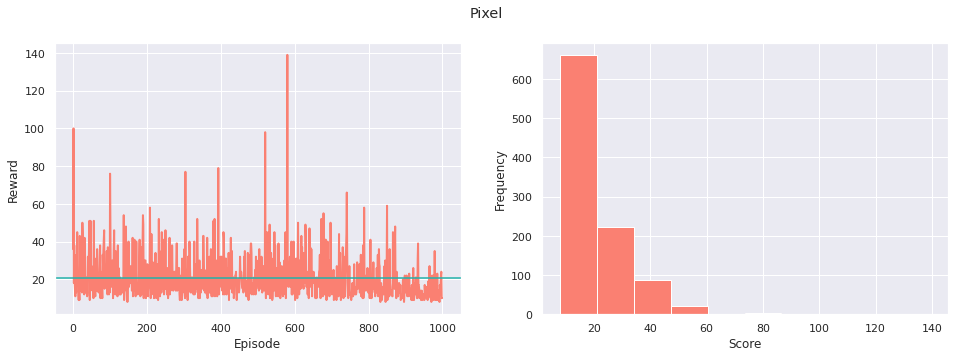

In [30]:
# Define the figure
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
f.suptitle("Pixel")

ax[0].plot(training_score,linewidth = 2 ,  color = 'salmon')
ax[0].axhline(np.mean(training_score),  color = 'lightseagreen')
ax[0].set_xlabel('Episode')
ax[0].set_ylabel('Reward')

ax[1].hist(training_score, color = 'salmon')
ax[1].set_xlabel('Score')
ax[1].set_ylabel('Frequency')

# Final test

In [31]:
# Initialize the Gym environment

env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

training_score=[]

# Let's try for a total of 10 episodes
for num_episode in range(10): 

    # Reset the environment and get the initial state
    state = env.reset()
    obs=preproces(env)

    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

        # Choose the action following the policy
        action, q_values = choose_action_softmax(policy_net, obs, temperature=tau)

        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        
        # We apply a (linear) penalty when the cart is far from center
        pos_weight = 1
        reward = reward - pos_weight * np.abs(state[0]) 
        
        # Update the final score (+1 for each step)
        score += 1

        # Apply penalty for bad state
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None
            next_state_obs=None
            
        if type(next_state)!="NoneType":
           
            next_state_obs = preproces(env)
            
        # Set the current state for the next iteration
        state = next_state
        obs=next_state_obs

   # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    
    
env.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


EPISODE: 1000 - FINAL SCORE: 10 - Temperature: 0.000984719194233056
EPISODE: 1000 - FINAL SCORE: 9 - Temperature: 0.000984719194233056
EPISODE: 1000 - FINAL SCORE: 8 - Temperature: 0.000984719194233056
EPISODE: 1000 - FINAL SCORE: 11 - Temperature: 0.000984719194233056
EPISODE: 1000 - FINAL SCORE: 8 - Temperature: 0.000984719194233056
EPISODE: 1000 - FINAL SCORE: 9 - Temperature: 0.000984719194233056
EPISODE: 1000 - FINAL SCORE: 10 - Temperature: 0.000984719194233056
EPISODE: 1000 - FINAL SCORE: 9 - Temperature: 0.000984719194233056
EPISODE: 1000 - FINAL SCORE: 9 - Temperature: 0.000984719194233056
EPISODE: 1000 - FINAL SCORE: 10 - Temperature: 0.000984719194233056
